Solver

In [2]:
using JuMP
using Gurobi
using CSV
using DataFrames
using Plots

Data Importation

In [3]:
budgets_demand = CSV.File("./data/budgets_demand.csv",header=0) |> Tables.matrix;
impression_data = CSV.File("./data/impression_per_age.csv",header=0) |> Tables.matrix; # plaform, age group, impressions rate
company_rcs_data = CSV.File("./data/company_rcs.csv",header=0) |> Tables.matrix; # company, rps
platform_variables_data = CSV.File("./data/platform_variables.csv",header=0) |> Tables.matrix; # platform, variable, value


Clean Data

In [4]:
# define dictionaries to use

# B: budget
budget_dict = Dict() # dict of (company) -> budget; 50 companies
for i in 2:size(budgets_demand,1)
    budget_dict[budgets_demand[i, 1]] = parse(Int, budgets_demand[i, 2])
end

# R_a: total reach demanded for each age group
demand_dict = Dict() # dict of (company, age group) -> demand; 50 companies, 4 age groups
age_groups = ["18-24", "25-34", "35-44", "45-60"]
for i in 2:size(budgets_demand,1)
    for j in 3:size(budgets_demand,2)
        demand_dict[(budgets_demand[i, 1], budgets_demand[1,j])] = parse(Int, budgets_demand[i,j])
    end
end

# impression rate per age group (a_ap*i_p)
impressions_per_age = Dict() # dict of (platform, age group) -> impression rate
for i in 2:size(impression_data,1)
    str_value = string(impression_data[i, 3])  # Convert to regular String
    impressions_per_age[(impression_data[i, 1], impression_data[i, 2])] = parse(Float64, str_value)  # Parse to Int
end


# company revenue per conversion
company_rcs = Dict() # dict of company -> r_c
for i in 1:size(company_rcs_data,2)
    # row 1 is company name, row 2 is r_c
    company_rcs[company_rcs_data[1, i]] = parse(Float64, company_rcs_data[2, i])
end

# platform variables
# constant for all companies need for each platform, 
    # w_p: click_rate
    # i_p: impression_rate
    # f_p: average_impression_rate
    # c_p: conversion rate
    # s_p: cost per click 

platform_variables = Dict() # dict of (platform, variable) -> value
for i in 2:size(platform_variables_data, 2)
    for j in 2:size(platform_variables_data, 1)
        platform_variables[platform_variables_data[1, i], platform_variables_data[j, 1]] = parse(Float64, platform_variables_data[j, i])
    end
end



In [5]:
const GRB_ENV = Gurobi.Env(output_flag=1);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-08


Solver

In [19]:
platforms_l = ["Facebook", "Instagram", "Twitter"] # keept this order
companies_l = collect(keys(budget_dict)) # keept this order
age_groups = ["18-24", "25-34", "35-44", "45-60"]


# model for each company
optimized_solutions= Dict() # dict of company -> {t -> [t_p], optimal_value -> value}

for i in 1:length(companies_l)
    company = companies_l[i]
    println("Optimizing for company: ", company)
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))

    ### decision variable ###
    # hours of advertisement allocated to platform p by company c: t_p
    @variable(model, t[1:length(platforms_l)] >= 0);

    ### constraints ###
    # reach for certain age group must reach a min
    @constraint(model, demand_constraints[a in 1:length(age_groups)], sum(((impressions_per_age[platforms_l[p], age_groups[a]] * t[p])/platform_variables[platforms_l[p], "f_p"] for p in 1:length(platforms_l))) >= demand_dict[company, age_groups[a]]);

    # budget constraint
    # @constraint(model, sum(platform_variables[platforms_l[p], "s_p"] * (platform_variables[platforms_l[p], "w_p"]*(platform_variables[platforms_l[p], "i_p"]*t[p])/platform_variables[platforms_l[p], "f_p"]) for p in 1:length(platforms_l)) <= budget_dict[company]);


    ### objective function ### 
    @objective(model, Min,
    sum((
        sum(platform_variables[platforms_l[p], "s_p"] * (platform_variables[platforms_l[p], "w_p"]*(platform_variables[platforms_l[p], "i_p"]*t[p])/platform_variables[platforms_l[p], "f_p"]) for p in 1:length(platforms_l)))
    ));

    optimize!(model)
    optimized_solutions[company] = Dict()


    

    dual_values = [dual(demand_constraints[a]) for a in 1:length(age_groups)]

    try
        optimized_solutions[company]["optimal_budget"] = objective_value(model)
        optimized_solutions[company]["t"] = value.(t)
        optimized_solutions[company]["dual_values"] = dual_values
        optimized_solutions[company]["revenue"] = a = sum([sum(((company_rcs[company]* platform_variables[platforms_l[p], "w_p"] * platform_variables[platforms_l[p], "c_p"] *impressions_per_age[platforms_l[p], age_groups[a]] * value.(t)[p])/platform_variables[platforms_l[p], "f_p"] for p in 1:length(platforms_l))) for a in 1:length(age_groups)
        ])

    catch e
        optimized_solutions[company]["optimal_budget"] = -1 # no solution
        optimized_solutions[company]["t"] = -1
    end
end



Optimizing for company: Silk & Style
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4 rows, 3 columns and 12 nonzeros
Model fingerprint: 0x94f3c9af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 1e+03]
Presolve time: 0.00s
Presolved: 4 rows, 3 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.702000e+03   0.000000e+00      0s
       3    1.4200969e+03   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.420096873e+03

User-callback calls 44, time in user-callback 0.00 sec
Optimizing for company: Vogue Visions
Gurobi Optimizer version 11.

In [21]:
# plot revenues and profits
for (company, solution) in optimized_solutions
    println("Company: ", company)
    println("Proposed budget: ", solution["optimal_budget"])
    println("Optimal t: ", solution["t"])
    println("Dual values: ", solution["dual_values"])
    println("Expected revenue: ", solution["revenue"])
    println()

    
end

Company: Silk & Style
Proposed budget: 1420.0968729971396
Optimal t: [101.70753826743356, 69.74248395642122, 434.3231083638419]
Dual values: [1.3310067988139076, 0.5333618956639448, 0.0, 0.369221773779798]
Expected revenue: 5158.974416598752

Company: Vogue Visions
Proposed budget: 1227.258491751657
Optimal t: [0.0, 174.47562427981862, 335.7126606225467]
Dual values: [2.818622454011731, 0.0, 0.08039597348061482, 0.0]
Expected revenue: 4049.1864142470363

Company: Hearth Harmony
Proposed budget: 1367.9654333968488
Optimal t: [0.0, 517.9866195764649, 0.0]
Dual values: [2.941861147089998, 0.0, 0.0, 0.0]
Expected revenue: 4597.27862556857

Company: Silicon Saga
Proposed budget: 1853.9465729011915
Optimal t: [0.0, 442.65064352741, 299.9975193002428]
Dual values: [2.8171893853441636, 0.11538566993997934, 0.0, 0.0]
Expected revenue: 5493.320970028422

Company: Furnish Fine
Proposed budget: 1518.4560548000272
Optimal t: [12.900600076853259, 9.105941637057153, 640.9675356830581]
Dual values: [1

Baselines - Random

In [22]:
platforms_l = ["Facebook", "Instagram", "Twitter"] # keept this order
companies_l = collect(keys(budget_dict)) # keept this order
age_groups = ["18-24", "25-34", "35-44", "45-60"]

baseline_random = Dict() # dict of company -> {t -> [t_p], optimal_value -> value}

for i in 1:length(companies_l)
    company = companies_l[i]

    # for each age group, pick a random platform
    t = [0.0, 0.0, 0.0]
    for a in 1:length(age_groups)
        # Calculate how much t is needed to meet that age gr demand
        platform_i = rand(1:3)
        platform = platforms_l[platform_i]

        t_needed = demand_dict[company, age_groups[a]] * platform_variables[platform, "f_p"] / impressions_per_age[platform, age_groups[a]]
        t[platform_i] += t_needed
    end

    baseline_random[company] = Dict()
    baseline_random[company]["t"] = t
    baseline_random[company]["random_budget"] = sum(platform_variables[platforms_l[p], "s_p"] * (platform_variables[platforms_l[p], "w_p"]*(platform_variables[platforms_l[p], "i_p"]*t[p])/platform_variables[platforms_l[p], "f_p"]) for p in 1:length(platforms_l))
    baseline_random[company]["revenue"] = sum([sum(((company_rcs[company]* platform_variables[platforms_l[p], "w_p"] * platform_variables[platforms_l[p], "c_p"] *impressions_per_age[platforms_l[p], age_groups[a]] * t[p])/platform_variables[platforms_l[p], "f_p"] for p in 1:length(platforms_l))) for a in 1:length(age_groups)
    ])
end


In [23]:
for (company, solution) in baseline_random
    println("Company: ", company)
    println("Optimal budget: ", solution["random_budget"])
    println("Optimal t: ", solution["t"])
    println("Expected revenue: ", solution["revenue"])
    println()
end

Company: Silk & Style
Optimal budget: 5841.778174525913
Optimal t: [414.7921413373871, 1315.2055415124814, 600.984387424013]
Expected revenue: 19558.040093286312

Company: Vogue Visions
Optimal budget: 4415.500598695187
Optimal t: [441.4408904934475, 454.49148556386604, 943.8443984194671]
Expected revenue: 14651.027668002385

Company: Hearth Harmony
Optimal budget: 2898.7385590914582
Optimal t: [760.5624616109048, 254.12537926365633, 175.56205143879922]
Expected revenue: 10852.286487307225

Company: Silicon Saga
Optimal budget: 4339.459578290217
Optimal t: [0.0, 95.41244466466263, 1790.28531569789]
Expected revenue: 14203.013045291107

Company: Furnish Fine
Optimal budget: 6202.441718209691
Optimal t: [851.4358120602452, 1574.2181880172598, 0.0]
Expected revenue: 17125.123050403665

Company: Gastronomy Guild
Optimal budget: 5437.831256996085
Optimal t: [1390.2754674607938, 301.74185625199556, 570.1261988656901]
Expected revenue: 17926.09322733932

Company: Dwell Delight
Optimal budget:

Baseline - Greedy

In [24]:
platforms_l = ["Facebook", "Instagram", "Twitter"] # keept this order
companies_l = collect(keys(budget_dict)) # keept this order
age_groups = ["18-24", "25-34", "35-44", "45-60"]

baseline_greedy = Dict() # dict of company -> {t -> [t_p], optimal_value -> value}

for i in 1:length(companies_l)
    company = companies_l[i]

    # for each age group, pick a random platform
    t = [0.0, 0.0, 0.0]
    for a in 1:length(age_groups)
        # Calculate how much t is needed to meet that age gr demand
        all_impressions = [impressions_per_age[platforms_l[p], age_groups[a]] for p in 1:length(platforms_l)]
        platform_i = argmax(all_impressions)
        platform = platforms_l[platform_i]

        t_needed = demand_dict[company, age_groups[a]] * platform_variables[platform, "f_p"] / impressions_per_age[platform, age_groups[a]]
        t[platform_i] += t_needed
    end

    baseline_greedy[company] = Dict()
    baseline_greedy[company]["t"] = t
    baseline_greedy[company]["greedy_budget"] = sum(platform_variables[platforms_l[p], "s_p"] * (platform_variables[platforms_l[p], "w_p"]*(platform_variables[platforms_l[p], "i_p"]*t[p])/platform_variables[platforms_l[p], "f_p"]) for p in 1:length(platforms_l))
    baseline_greedy[company]["revenue"] = sum([sum(((company_rcs[company]* platform_variables[platforms_l[p], "w_p"] * platform_variables[platforms_l[p], "c_p"] *impressions_per_age[platforms_l[p], age_groups[a]] * t[p])/platform_variables[platforms_l[p], "f_p"] for p in 1:length(platforms_l))) for a in 1:length(age_groups)
    ])
end


In [25]:
for (company, solution) in baseline_greedy
    println("Company: ", company)
    println("Optimal budget: ", solution["greedy_budget"])
    println("Optimal t: ", solution["t"])
    println("Expected revenue: ", solution["revenue"])
    println()
end

Company: Silk & Style
Optimal budget: 4290.258835989907
Optimal t: [0.0, 893.2635006143314, 845.8567299611377]
Expected revenue: 14614.216711760677

Company: Vogue Visions
Optimal budget: 3796.1886621810054
Optimal t: [0.0, 712.900189863994, 838.0851569646285]
Expected revenue: 12261.56461920713

Company: Hearth Harmony
Optimal budget: 2372.378060999512
Optimal t: [0.0, 714.3772348445622, 212.75870995666682]
Expected revenue: 8292.658810459716

Company: Silicon Saga
Optimal budget: 4272.701857188223
Optimal t: [0.0, 788.2891702056545, 959.5913401918096]
Expected revenue: 12991.722835734516

Company: Furnish Fine
Optimal budget: 4543.916162208385
Optimal t: [0.0, 907.5328654046615, 940.4512019946974]
Expected revenue: 13111.388365353832

Company: Gastronomy Guild
Optimal budget: 4599.141693697969
Optimal t: [0.0, 1248.599117843383, 570.1261988656901]
Expected revenue: 14141.27923418495

Company: Dwell Delight
Optimal budget: 4510.703310233743
Optimal t: [0.0, 1104.6916451207999, 697.849

# Revenue Graphs

In [27]:
# grouped bar chart showing the revenue of each company using the optimal solution, random solution, and greedy solution
using Plots

# Example dictionary: mapping companies to revenue predictions for 3 models

model_rev = []
random_rev = []
greedy_rev = []
companies = []

for company in companies_l
    push!(model_rev, optimized_solutions[company]["revenue"])
    push!(random_rev, baseline_random[company]["revenue"])
    push!(greedy_rev, baseline_greedy[company]["revenue"])
    push!(companies, company)
end

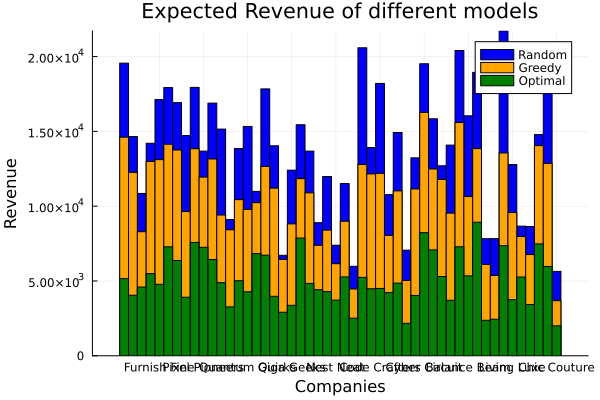

In [32]:
# Create a grouped bar chart
bar(
    companies,
    [random_rev greedy_rev model_rev],  # Combine model data into a matrix
    label=["Random" "Greedy" "Optimal"],
    xlabel="Companies",
    ylabel="Revenue",
    title="Expected Revenue of different models",
    legend=:topright,
    bar_width=1,
    color=[:blue :orange :green],
)

In [172]:
plot(
    companies,
    [random_rev greedy_rev model_rev],  # Combine model data into a matrix
    label=["Random" "Greedy" "Optimal"],
    xlabel="Companies",
    ylabel="Revenue",
    title="Expected Revenue of different models",
    legend=:topright,
    lw=2,  # Line width
    markershape=:circle,
    markerstrokewidth=1.5,
    xtickfontsize=8,    # Font size for the x-axis tick labels
    xrotation=45,      # Rotate the x-axis tick labels by 45 degrees
    # include 50 ticks on the x-axis
    xticks=(1:50, companies),
    color=[:blue :orange :green],
    size = (1100, 600),
)

# Save the plot to a file
savefig("revenue_comparison.png")

"c:\\Users\\hbori\\Documents\\MIT env\\15_C57\\final proj\\Optimization-final-project\\revenue_comparison.png"

# Profit plots

In [47]:
model_profit = []
random_profit = []
greedy_profit = []
companies = []

for company in companies_l
    push!(model_profit, optimized_solutions[company]["revenue"] - optimized_solutions[company]["optimal_budget"])
    push!(random_profit, baseline_random[company]["revenue"] - baseline_random[company]["random_budget"])
    push!(greedy_profit, baseline_greedy[company]["revenue"] - baseline_greedy[company]["greedy_budget"])
    push!(companies, company)
end

In [174]:

plot(
    companies,
    [random_profit greedy_profit model_profit],  # Combine model data into a matrix
    label=["Random" "Greedy" "Optimal"],
    xlabel="Companies",
    ylabel="Profit",
    title="Expected Profit of different models",
    legend=:topright,
    lw=2,  # Line width
    markershape=:circle,
    markerstrokewidth=1.5,
    xtickfontsize=8,    # Font size for the x-axis tick labels
    xrotation=45,      # Rotate the x-axis tick labels by 45 degrees
    # include 50 ticks on the x-axis
    xticks=(1:50, companies),
    color=[:blue :orange :green],
    size = (1100, 600),
)

# Save the plot to a file
savefig("profit_comparison.png")

"c:\\Users\\hbori\\Documents\\MIT env\\15_C57\\final proj\\Optimization-final-project\\profit_comparison.png"

# Profit and Revenue same graph

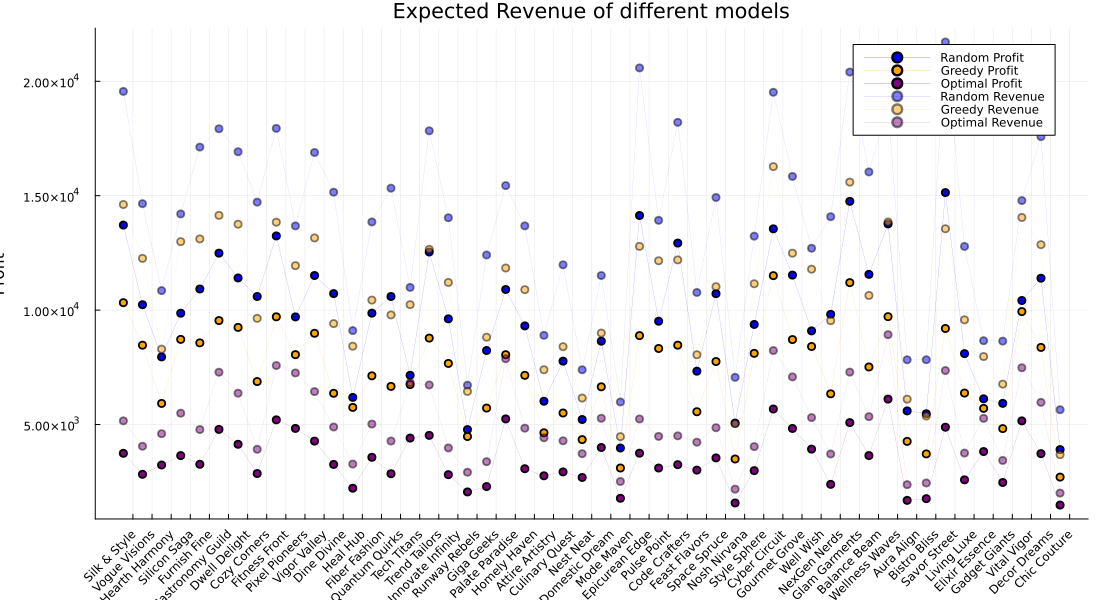

In [59]:
plot(
    companies,
    [random_profit greedy_profit model_profit random_rev greedy_rev model_rev],  # Combine model data into a matrix
    label=["Random Profit" "Greedy Profit" "Optimal Profit" "Random Revenue" "Greedy Revenue" "Optimal Revenue"],
    alpha=[1.0 1.0 1.0 0.5 0.5 0.5],
    xlabel="Companies",
    ylabel="Profit",
    title="Expected Revenue of different models",
    legend=:topright,
    bar_width=1,
    color=[:blue :orange :purple],
    markershape=:circle,
    markerstrokewidth=1.5,
    linewidth=0.1,
    xtickfontsize=8,
    xrotation=45,
    xticks=(1:length(companies), companies),
    size=(1100, 600)
)

# Dual variable

In [67]:
agegroup1 = []
agegroup2 = []
agegroup3 = []
agegroup4 = []

dual1 = []
dual2 = []
dual3 = []
dual4 = []
companies = []

for company in companies_l
    
    push!(agegroup1, demand_dict[company, age_groups[1]])
    push!(agegroup2, demand_dict[company, age_groups[2]])
    push!(agegroup3, demand_dict[company, age_groups[3]])
    push!(agegroup4, demand_dict[company, age_groups[4]])

    push!(dual1, optimized_solutions[company]["dual_values"][1])
    push!(dual2, optimized_solutions[company]["dual_values"][2])
    push!(dual3, optimized_solutions[company]["dual_values"][3])
    push!(dual4, optimized_solutions[company]["dual_values"][4])
    push!(companies, company)
end

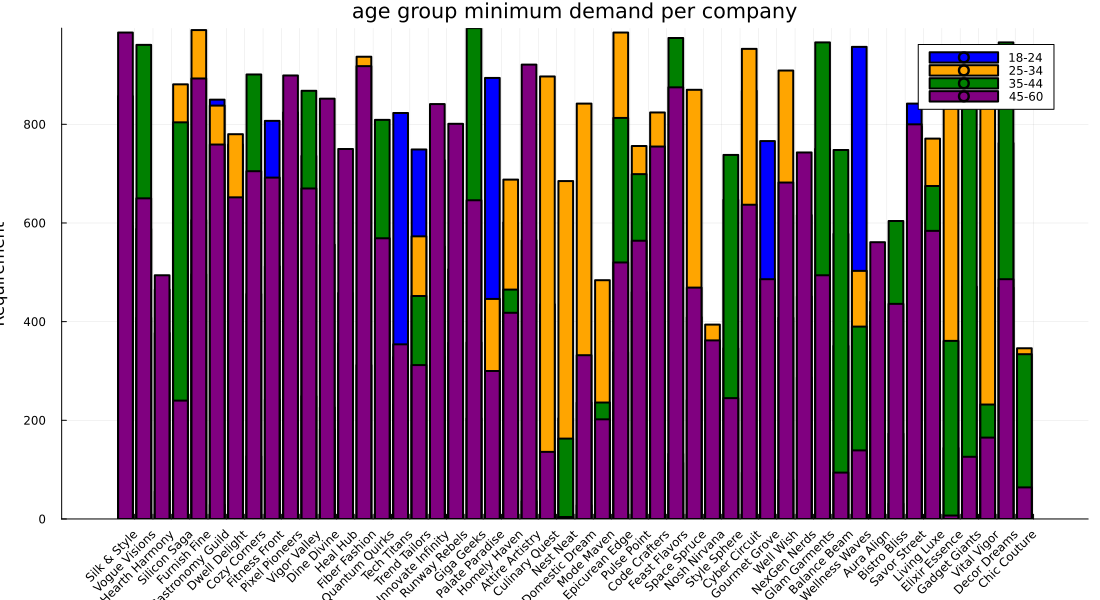

In [68]:
# bar graph of dual values for each company

bar(
    companies,
    [agegroup1 agegroup2 agegroup3 agegroup4],  # Combine model data into a matrix
    label=["18-24" "25-34" "35-44" "45-60"],
    xlabel="Companies",
    ylabel="Requirement",
    title="age group minimum demand per company",
    legend=:topright,
    lw=2,  # Line width
    markershape=:circle,
    markerstrokewidth=1.5,
    xtickfontsize=8,    # Font size for the x-axis tick labels
    xrotation=45,      # Rotate the x-axis tick labels by 45 degrees
    # include 50 ticks on the x-axis
    xticks=(1:50, companies),
    color=[:blue :orange :green :purple],
    size = (1100, 600),
)

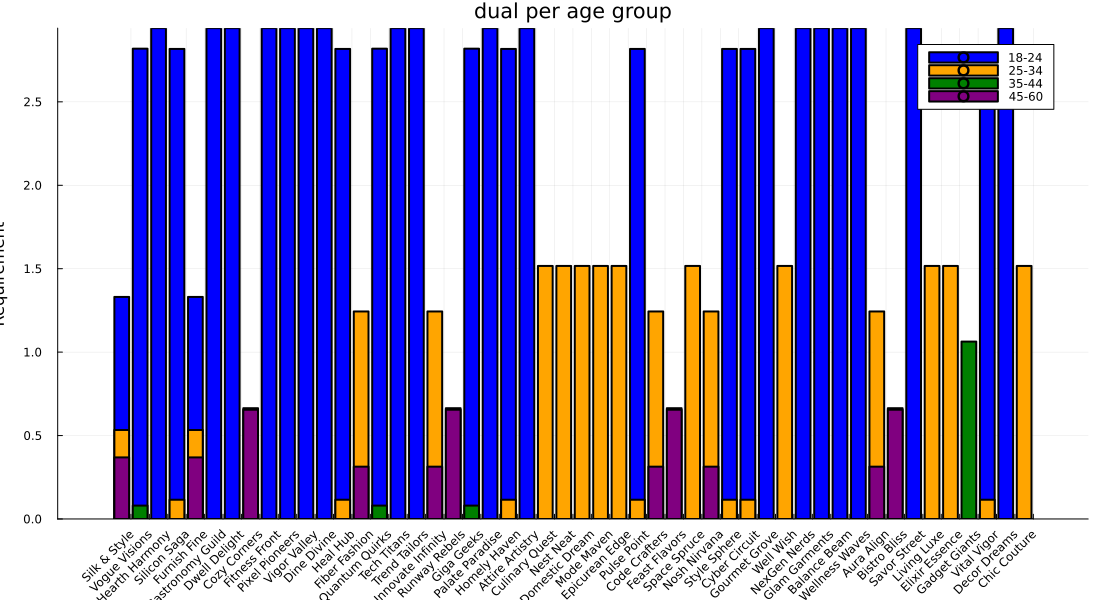

In [70]:
bar(
    companies,
    [dual1 dual2 dual3 dual4],  # Combine model data into a matrix
    label=["18-24" "25-34" "35-44" "45-60"],
    xlabel="Companies",
    ylabel="Requirement",
    title="dual per age group",
    legend=:topright,
    lw=2,  # Line width
    markershape=:circle,
    markerstrokewidth=1.5,
    xtickfontsize=8,    # Font size for the x-axis tick labels
    xrotation=45,      # Rotate the x-axis tick labels by 45 degrees
    # include 50 ticks on the x-axis
    xticks=(1:50, companies),
    color=[:blue :orange :green :purple],
    size = (1100, 600),
)

In [165]:
# For each company, extract data for the 4 age groups
plts = []

for i in 1:10
    x_vals = [agegroup1[i], agegroup2[i], agegroup3[i], agegroup4[i]]  #Minimum requirements for the 4 age groups
    y_vals = [dual1[i], dual2[i], dual3[i], dual4[i]]       # Dual values for the 4 age groups
    labels=["18-24" "25-34" "35-44" "45-60"]

    # Create a scatter plot for this company
    p = scatter(
        x_vals,  # x-axis: Minimum requirements
        y_vals,  # y-axis: Dual values
        xlabel="Minimum Demand for Age Group",  # Label for x-axis
        ylabel="Dual Value",           # Label for y-axis
        title="$(companies[i])",  # Title with company name
        # label=labels,  # Label for the scatter plot
        # legend=:topright,  # No legend for scatter plot
        legend = false,
        marker=:circle,  # Marker type
        color=[:blue, :green, :orange, :red],  # Color for the points
        size=(100, 100),  # Plot size
        titlefontsize=8,  # Font size for the title
        xtickfontsize=4,  # Font size for the x-axis labels
        xlabelfontsize=6,  # Font size for the x-axis label
        ylabelfontsize=6,  # Font size for the y-axis label
    )

    push!(plts, p)  # Add this plot to the list of plots
end   

In [169]:
rows, cols = 2, 5
per_graph = 200
plot(plts..., layout=(rows, cols), size=(cols*per_graph, rows*per_graph))  # Combine all plots into a grid layout

# save
savefig("dual_values.png")

"c:\\Users\\hbori\\Documents\\MIT env\\15_C57\\final proj\\Optimization-final-project\\dual_values.png"